# Семинар 2
Prophet

In [ ]:
import os
import pandas as pd

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd


init_notebook_mode(connected = True)

In [ ]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
%pylab inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [ ]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda)

## Загрузка и предобработка данных

In [50]:
habr_df = pd.read_csv('https://raw.githubusercontent.com/denyscherevyk/mlcourse_open-1/master/data/howpop_train.csv')

In [51]:
habr_df_1=habr_df

In [62]:
habr_df['published'] = pd.to_datetime(habr_df.published)
habr_df = habr_df[['published', 'url']]
habr_df = habr_df.drop_duplicates()

In [5]:
aggr_habr_df = habr_df.groupby('published')[['url']].count()
aggr_habr_df.columns = ['posts']

In [6]:
aggr_habr_df = aggr_habr_df.resample('D').apply(sum)
plotly_df(aggr_habr_df.resample('W').apply(sum), title = 'Опубликованные посты на Хабрахабре')

## Построение прогноза Prophet

In [43]:
from fbprophet import Prophet
# приводим dataframe к нужному формату
df = aggr_habr_df.reset_index()
data = df
df.columns = ['ds', 'y']

# отрезаем из обучающей выборки последние 30 точек, чтобы измерить на них качество
train_df = df[:-predictions] 

In [55]:
habr_df_1.head(1)

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,-0.792687,-1.344075,-2.436871


In [22]:
predictions = 30

train_df = aggr_habr_df[:-predictions]
train_df.reset_index(inplace=True)
train_df.columns = ['ds', 'y']
train_df.tail()

# Python
m = Prophet()
m.fit(train_df);

future = m.make_future_dataframe(periods=predictions)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
3222,2016-10-27,67.459482,52.259833,80.588445
3223,2016-10-28,63.656446,48.788860,78.587491
3224,2016-10-29,35.675364,20.776155,48.622007
3225,2016-10-30,38.100308,23.587921,52.838608
3226,2016-10-31,68.549648,53.718730,83.879777


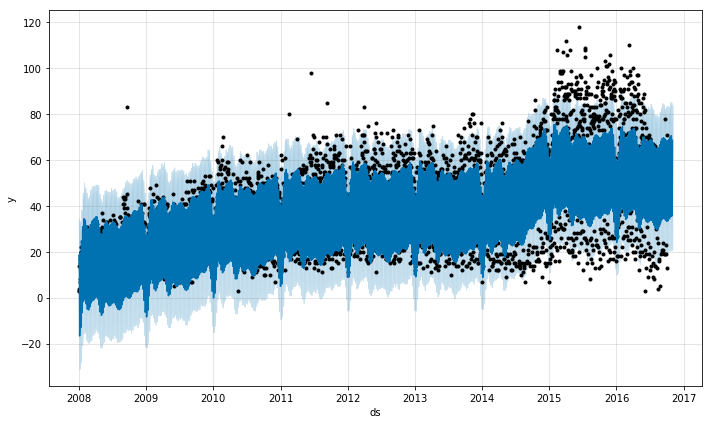

In [23]:
m.plot(forecast);

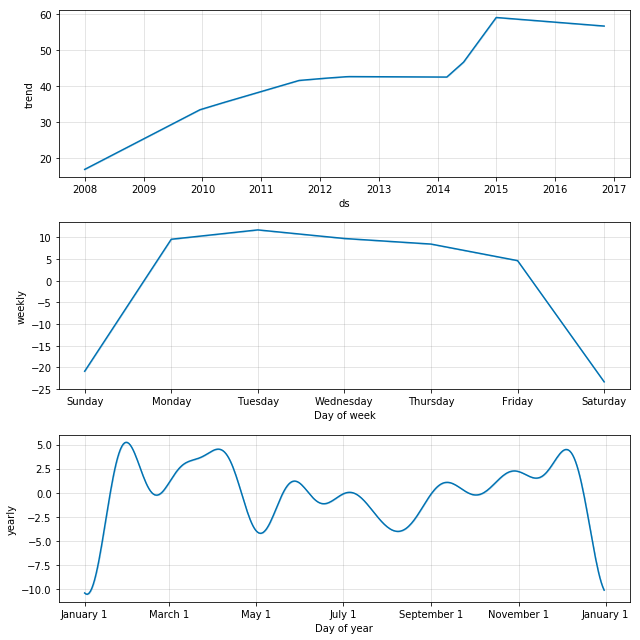

In [24]:
m.plot_components(forecast);

## Оценка качества Prophet

In [25]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [26]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

(37.63597532826898, 10.706600548405373)

In [27]:
print ('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print ('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 37.63597532826898
MAE 10.706600548405373
